In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d oluwaseunad/concrete-and-pavement-crack-images

 96% 305M/319M [00:02<00:00, 139MB/s]
100% 319M/319M [00:03<00:00, 107MB/s]


In [ ]:
!unzip -q concrete-and-pavement-crack-images.zip

In [ ]:
!ls

concrete-and-pavement-crack-images.zip	kaggle.json  Negative  Positive  sample_data


In [ ]:
import os
import time
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
import json
from tensorflow.keras.models import model_from_json
import tensorflow as tf

In [ ]:
path_Negative = '/content/Negative'

In [ ]:
path_Positive = '/content/Positive'

In [ ]:
positive_images = [os.path.join(path_Positive, img) for img in os.listdir(path_Positive)]
negative_images = [os.path.join(path_Negative, img) for img in os.listdir(path_Negative)]

In [ ]:
print("Positive folder contents:")
print(len(os.listdir(path_Positive)))

Positive folder contents:
15000


In [ ]:
all_images = positive_images + negative_images
labels = ['1'] * len(positive_images) + ['0'] * len(negative_images)  # Convert to strings

In [ ]:
df_train = pd.DataFrame(list(zip(all_images, labels)), columns=['Filepath', 'Label'])

In [ ]:
df_train = shuffle(df_train, random_state=42)

In [ ]:
df_train.head(5)

,Filepath,Label
2308,/content/Positive/14606.jpg,1
22404,/content/Negative/14409.jpg,0
23397,/content/Negative/05699.jpg,0
25058,/content/Negative/03792.jpg,0
2664,/content/Positive/02665.jpg,1


In [ ]:
df_train["Label"].value_counts()

1    15000
0    15000
Name: Label, dtype: int64

In [ ]:
train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='Filepath',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='Filepath',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=64,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='Filepath',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df,test_df)

Found 24000 validated image filenames belonging to 2 classes.
Found 24000 validated image filenames belonging to 2 classes.
Found 6000 validated image filenames belonging to 2 classes.


In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              mode='auto')]
    return model, my_callbacks

In [ ]:
ResNet50_model, callback=func(ResNet50)

In [ ]:
ResNet50_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
start_time = time.time()

In [ ]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=10,
    callbacks=callback
)

Epoch 1/10
375/375 [==============================] - 70s 177ms/step - loss: 0.0273 - accuracy: 0.9904 - val_loss: 0.0063 - val_accuracy: 0.9984
Epoch 2/10
375/375 [==============================] - 74s 198ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0048 - val_accuracy: 0.9984
Epoch 3/10
375/375 [==============================] - 65s 174ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0069 - val_accuracy: 0.9980


In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds")

Elapsed time: 219.68733072280884 seconds


In [ ]:
def plot(history,df_test,test_gen,train_gen):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

    # Predict Data Test
    pred = ResNet50_model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["0", "1"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.Filepath.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

94/94 [==============================] - 10s 95ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2957
           1       1.00      1.00      1.00      3043

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



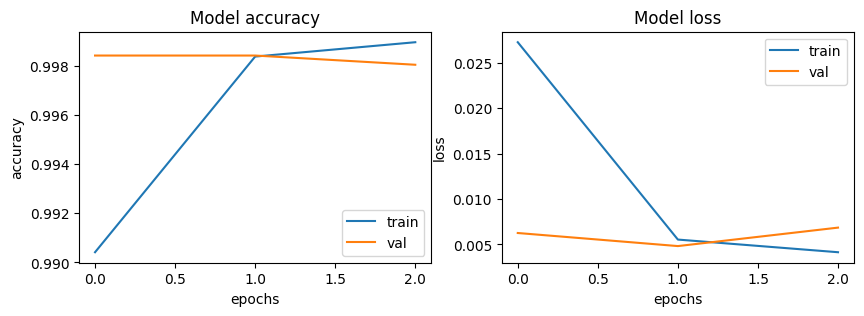

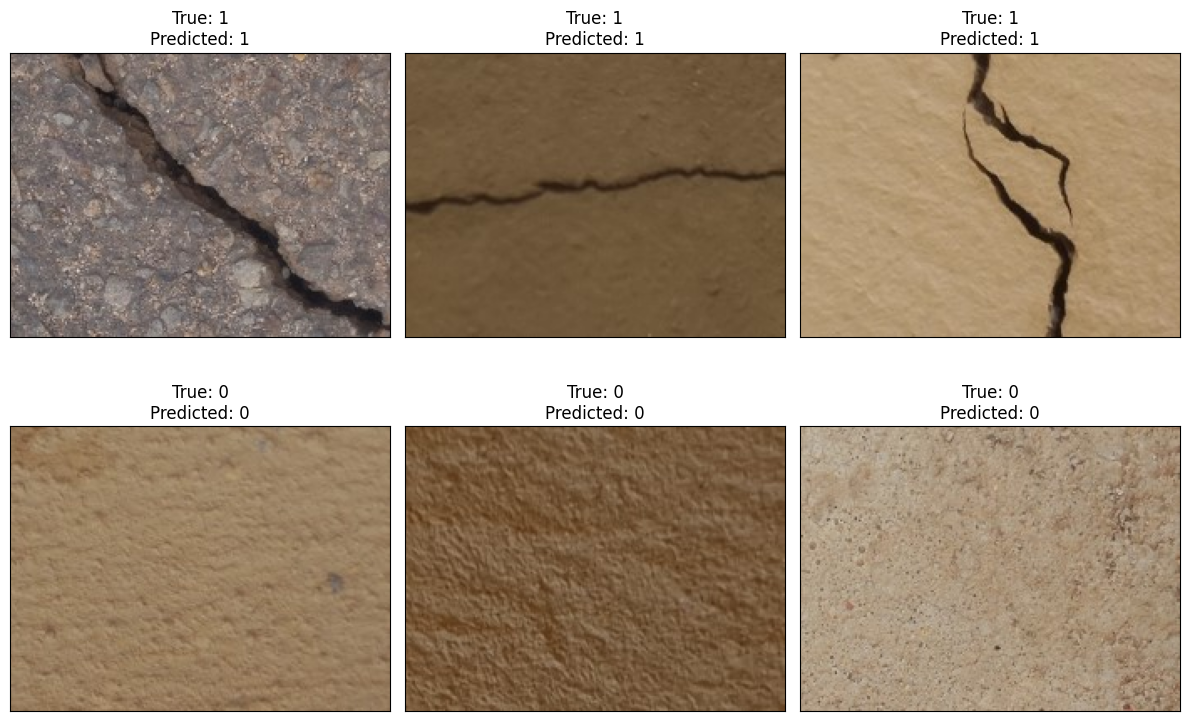

In [ ]:
history_ResNet=plot(history,test_df,test_gen_RestNet,train_gen_RestNet)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score

def result_test(test, model_use):
    results = model_use.evaluate(test, verbose=0)

    y_pred = np.argmax(model_use.predict(test), axis=1)
    y_true = test.classes  # Assuming test.labels contains the true labels

    f1 = f1_score(y_true, y_pred, average='weighted')
    roc = roc_auc_score(y_true, y_pred, multi_class='ovr')

    print("Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    print("F1 Score: {:.2f}".format(f1))
    print("ROC AUC: {:.2f}".format(roc))

    return results, f1, roc



In [ ]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

94/94 [==============================] - 9s 94ms/step
[[3.4287684e-14 1.0000000e+00]
 [2.3181169e-08 1.0000000e+00]
 [1.7570245e-07 9.9999988e-01]
 ...
 [1.0000000e+00 1.2890949e-08]
 [4.9691848e-12 1.0000000e+00]
 [1.4920735e-09 1.0000000e+00]]
94/94 [==============================] - 8s 81ms/step
Test Loss: 0.00952
Test Accuracy: 99.73%
F1 Score: 1.00
ROC AUC: 1.00


In [ ]:
# Save the model architecture and weights
ResNet50_model.save("resnet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("resnet_model.h5")
loaded_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# preprocessed_image = preprocess_input("image_path")
# prediction = loaded_model.predict(preprocessed_image)

In [ ]:
result_ResNet = result_test(test_gen_RestNet,loaded_model)

94/94 [==============================] - 9s 96ms/step
Test Loss: 0.00952
Test Accuracy: 99.73%
F1 Score: 1.00
ROC AUC: 1.00


# **Testing model on new dataset**

In [ ]:
!kaggle datasets download -d thesighsrikar/concrete-crack-images-for-classification

 96% 225M/234M [00:02<00:00, 111MB/s] 
100% 234M/234M [00:02<00:00, 119MB/s]


In [ ]:
!unzip -q concrete-crack-images-for-classification.zip

In [ ]:
!ls

Concrete				      kaggle.json	       Negative_train
concrete-and-pavement-crack-images.zip	      model_architecture.json  Positive_train
concrete-crack-images-for-classification.zip  model_weights.h5	       sample_data


In [ ]:
path_Negative = '/content/Concrete/Negative1'

In [ ]:
path_Positive = '/content/Concrete/Positive1'

In [ ]:
positive_images = [os.path.join(path_Positive, img) for img in os.listdir(path_Positive)]
negative_images = [os.path.join(path_Negative, img) for img in os.listdir(path_Negative)]

In [ ]:
all_images = positive_images + negative_images
labels = ['1'] * len(positive_images) + ['0'] * len(negative_images)  # Convert to strings

In [ ]:
df_test1 = pd.DataFrame(list(zip(all_images, labels)), columns=['Filepath', 'Label'])

In [ ]:
df_test1 = shuffle(df_test1, random_state=42)

In [ ]:
df_test1.head()

,Filepath,Label
32823,/content/Concrete/Negative1/06092.jpg,0
16298,/content/Concrete/Positive1/02032.jpg,1
28505,/content/Concrete/Negative1/04179.jpg,0
6689,/content/Concrete/Positive1/04642.jpg,1
26893,/content/Concrete/Negative1/11946.jpg,0


In [ ]:
df_test1.describe()

,Filepath,Label
count,40000,40000
unique,40000,2
top,/content/Concrete/Negative1/06092.jpg,0
freq,1,20000


In [ ]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 32823 to 15795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  40000 non-null  object
 1   Label     40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


In [ ]:
no_of_test_examples = 40000

In [ ]:
df_test1 = df_test1.head(no_of_test_examples)

In [ ]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 32823 to 15795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  40000 non-null  object
 1   Label     40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB


In [ ]:
df_test1.head()

,Filepath,Label
32823,/content/Concrete/Negative1/06092.jpg,0
16298,/content/Concrete/Positive1/02032.jpg,1
28505,/content/Concrete/Negative1/04179.jpg,0
6689,/content/Concrete/Positive1/04642.jpg,1
26893,/content/Concrete/Negative1/11946.jpg,0


In [ ]:
test_datagen = ImageDataGenerator(
                        preprocessing_function=RestNet_pre)


test_gen = test_datagen.flow_from_dataframe(
        dataframe=df_test1,
        x_col='Filepath',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )


Found 40000 validated image filenames belonging to 2 classes.


In [ ]:
result_ResNet = result_test(test_gen,ResNet50_model)

625/625 [==============================] - 46s 73ms/step
Test Loss: 0.02117
Test Accuracy: 99.33%
F1 Score: 0.99
ROC AUC: 0.99


In [ ]:
!kaggle datasets download -d aniruddhsharma/structural-defects-network-concrete-crack-images

 99% 500M/506M [00:10<00:00, 70.3MB/s]
100% 506M/506M [00:10<00:00, 50.8MB/s]


In [ ]:
!unzip -q structural-defects-network-concrete-crack-images.zip

In [ ]:
!ls

Concrete				      Pavements
concrete-and-pavement-crack-images.zip	      Positive_
concrete-crack-images-for-classification.zip  Positive__
Decks					      Positive_train
kaggle.json				      sample_data
Negative_				      structural-defects-network-concrete-crack-images.zip
Negative__				      Walls
Negative_train


In [ ]:
path_Negative = '/content/Walls/Non-cracked'

In [ ]:
path_Positive = '/content/Walls/Cracked'

In [ ]:
positive_images = [os.path.join(path_Positive, img) for img in os.listdir(path_Positive)]
negative_images = [os.path.join(path_Negative, img) for img in os.listdir(path_Negative)]

In [ ]:
all_images = positive_images + negative_images
labels = ['1'] * len(positive_images) + ['0'] * len(negative_images)  # Convert to strings

In [ ]:
df_test2 = pd.DataFrame(list(zip(all_images, labels)), columns=['Filepath', 'Label'])

In [ ]:
df_test2 = shuffle(df_test2, random_state=42)

In [ ]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18138 entries, 10349 to 15795
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  18138 non-null  object
 1   Label     18138 non-null  object
dtypes: object(2)
memory usage: 425.1+ KB


In [ ]:
test_datagen = ImageDataGenerator(
                        preprocessing_function=RestNet_pre)


test_gen = test_datagen.flow_from_dataframe(
        dataframe=df_test2,
        x_col='Filepath',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )


Found 18138 validated image filenames belonging to 2 classes.


In [ ]:
result_ResNet = result_test(test_gen,ResNet50_model)

284/284 [==============================] - 21s 74ms/step
Test Loss: 1.11068
Test Accuracy: 82.02%
F1 Score: 0.77
ROC AUC: 0.59
